# Problem

Given a rectangular and unit length cake, suppose that:
* two candles are placed uniform at random along the length
* a knife cuts the cake at a uniform random position along the length

**What is the probability that the knife cuts between the two candles?**

## Problem History

I originally saw this problem presented by Ben Sparks on Numberphile https://www.youtube.com/watch?v=FkVe8qrT0LA. 

This problems seems to have been around before hand though as I found it on New Scientist https://www.newscientist.com/article/mg24232361-100-puzzle-09-the-cake-and-the-candles/

# Simulation

In [1]:
from scipy.stats import uniform
import numpy as np

n_rvs = 1000000
rvs_c1 = uniform.rvs(size=n_rvs)
rvs_c2 = uniform.rvs(size=n_rvs)
rvs_ck = uniform.rvs(size=n_rvs)

way1 = (rvs_c1 < rvs_ck) & (rvs_c2 > rvs_ck)
way2 = (rvs_c1 > rvs_ck) & (rvs_c2 < rvs_ck)

total = way1 | way2
np.sum(total)/n_rvs

0.333139

# Analytic Solution

## Problem Statement

Let:
- $C_1$, $C_2 \sim U(0,1)$ be the candle positions
- $K \sim U(0,1)$ be the knife position

Let the probability that the knife cuts between the two cuts be
$$P(C_{1,2}<K<C_{1,2}) = P(C_1 < K < C_2) + P(C_2 < K < C_1)$$

Since these variables are uniform random we know that 
$$P(C_1 < K < C_2) = P(C_2 < K < C_1).$$

Therefore we only need to derive an equation for one side and
$$P(C_{1,2}<K<C_{1,2}) = 2 \cdot P(C_1 < K < C_2).$$

We can further decompose as

$$P(C_1 < K < C_2) = P(C_1 - K < 0\ \mathrm{and}\ C_2 - K > 0).$$

## Objective Part 1

Let $X=C_1 - K$ and $Y=C_2 - K$ then

$$P(C_1 < K < C_2) = P(X < 0\ \mathrm{and}\ Y > 0)$$

The difference of two standard uniform random variables is Triangular distributed i.e.

$$C_1 - K \sim \text{Triangular}(-1, 0, 1)$$

Alternatively defining $Y=K - C_2$ then 

$$P(C_1 < K < C_2) = P(X < 0\ \mathrm{and}\ Y < 0)$$

The joint cumulative probability is given by
$$ P(X < 0\ \mathrm{and}\ Y < 0) = P(X < 0, Y < 0) = \int_{-1}^0 \int_{-1}^0 f_{X,Y}(x,y) \, dx \, dy$$
where $f_{X,Y}(x,y)$ is the joint density of $X$ and $Y$.

## Joint Density

The joint density can be decomposed into

$$f_{X,Y}(x,y) = f_{Y\mid X}(y\mid x)f_X(x) = f_{X\mid Y}(x\mid y)f_Y(y)$$

The marginals $f_X(x)$ and $f_Y(y)$ are given by the PDFs from the Triangular distributions for each $X$ and $Y$.

The conditional probability density $f_{X\mid Y}(x\mid y)$ can be established through the shared variable $K$ in both $X$ and $Y$.

Given a specific value $y$ for $Y$, one can establish the support of $K$, through the relation $Y = K-C_2$, which is

$$K \in [\max(y, 0), \min(1, 1+y)]$$

i.e. $K \sim U(\max(y, 0), \min(1, 1+y))$.

Since no information is known about $C_1$ we assume it still follows a standard uniform distribution.

The difference of two uniform variables with different supports is trapezoidal distributed. Trapezoidal distributions have four parameters: $a$, $b$, $c$, $d$; that correspond to the lower bound, first bend, second bend and upper bound respectively.

Let $F \sim U(l,m)$ and $G \sim U(n, o)$ and $H = F-G$ then

$$H\sim \text{Trapezoidal}(l-o,l-n,m-o,m-n)$$

Therefore for a known value of $Y$ the distribution of $X$ is

$$X_{Y = y} \sim \text{Trapezoidal}(-\min(1, 1+y), -\max(y, 0), 1-\min(1, 1+y), 1-\max(y, 0))$$

and the conditional probability density $f_{X\mid Y}$ can be drawn from this distribution.

## Solution

Solving the objective yields

$$P(C_1 < K < C_2)=\frac{1}{6}$$

therefore

$$P(C_{1,2}<K<C_{1,2}) = 2 \cdot P(C_1 < K < C_2) = 2 \cdot \frac{1}{6} = \frac{1}{3}$$

# Reference Implementation

In [2]:
import numpy as np
from scipy.integrate import dblquad
from scipy.stats import trapezoid, triang
import time

# Used for tighter inner integral bounds
def x_lower(y):
    # Support of K
    k_range = [np.maximum(y, 0), np.minimum(1, 1+y)]

    # Support of C1
    c1_range = [0, 1]

    # Conventional trapezoid parameters
    a = c1_range[0] - k_range[1]
    
    return a

def x_upper(y):
    # Support of K
    k_range = [np.maximum(y, 0), np.minimum(1, 1+y)]

    # Support of C1
    c1_range = [0, 1]

    # Conventional trapezoid parameters
    d = c1_range[1] - k_range[0]
    
    return np.minimum(d, 0)

def f(y, x):
    # Y marginal
    y_density = triang.pdf(y, loc=-1, scale=2, c=0.5)

    # Support of K
    k_range = [np.maximum(y, 0), np.minimum(1, 1+y)]

    # Support of C1
    c1_range = [0, 1]

    # Conventional trapezoid parameters
    a = c1_range[0] - k_range[1]
    b = c1_range[0] - k_range[0]
    c = c1_range[1] - k_range[1]
    d = c1_range[1] - k_range[0]

    # Scipy trapezoid parameters
    loc = a
    scale = d-a
    c1 = (b-a) / scale
    d1 = (c-a) / scale

    # X conditional probability density
    x_density = trapezoid.pdf(x,c=c1, d=d1,loc=loc, scale=scale)

    return y_density*x_density

s = time.time()
p = dblquad(f, a=-1, b=0, gfun=x_lower, hfun=x_upper)[0]
print(f"Probability: {p*2}")
print(f"Calculated in {time.time()-s:.4f} seconds")

Probability: 0.33333333333333337
Calculated in 0.1640 seconds


# Optimised Python Implementation

In [3]:
from scipy.integrate import dblquad
import time
from math import fabs
s = time.time()

def x_lower(y):
    return 0 - (1+y if y<0 else 1)

def x_upper(y):
    d = 1 - (y if y>0 else 0)
    return d if d>0 else 0

def f(y, x):
    # Y marginal
    y_density = -fabs(y) + 1

    # Support of K
    k_range0 = y if y>0 else 0
    k_range1 = 1+y if y<0 else 1

    # Conventional trapezoid parameters
    a = 0 - k_range1
    b = 0 - k_range0
    c = 1 - k_range1
    d = 1 - k_range0

    # X conditional probability density
    x_density = (2/(d+c-a-b))
    
    if x < b:
        x_density = x_density*((x-a)/(b-a))
        x_density = x_density if x_density>0 else 0
    elif x > c:
        x_density = x_density*((d-x)/(d-c))
        x_density = x_density if x_density>0 else 0
    
    return y_density*x_density

tol = 1e-06 # Increase for even faster results
st = time.time()
p = dblquad(f, a=-1, b=0, gfun=x_lower, hfun=lambda x: 0)[0]
en = time.time()
print(f"Probability: {p*2}")
print(f"Calculated in {en-st:.4f} seconds")

Probability: 0.33333333333333337
Calculated in 0.0003 seconds


# Optimised Cython Implementation

In [4]:
%load_ext cython

In [5]:
%%cython
from scipy.integrate import dblquad
from libc.math cimport abs
import cython
import time
import numpy as np

def x_lower(y):
    return 0 - (1+y if y<0 else 1)

def x_upper(y):
    d = 1 - (y if y>0 else 0)
    return d if d>0 else 0

@cython.cdivision(True)
def f(y: cython.double, x: cython.double):
    # Y marginal
    cdef double y_density = -abs(y) + 1

    # Support of K
    cdef double k_range0 = y if y>0 else 0.0
    cdef double k_range1 = 1+y if y<0 else 1.0

    # Conventional trapezoid parameters
    cdef double a = 0.0 - k_range1
    cdef double b = 0.0 - k_range0
    cdef double c = 1.0 - k_range1
    cdef double d = 1.0 - k_range0

    # X conditional probability density
    cdef double x_density = (2.0/(d+c-a-b))
    
    if x < b:
        x_density = x_density*((x-a)/(b-a))
        x_density = x_density if x_density>0 else 0.0
    elif x > c:
        x_density = x_density*((d-x)/(d-c))
        x_density = x_density if x_density>0 else 0.0
    
    return y_density*x_density

tol = 1e-06 # Increase for even faster results
st = time.time()
p = dblquad(f, a=-1, b=0, gfun=x_lower, hfun=lambda x: 0)[0]
en = time.time()
print(f"Probability: {p*2}")
print(f"Calculated in {en-st:.4f} seconds")

Probability: 0.33333333333333337
Calculated in 0.0001 seconds


# Visualisation

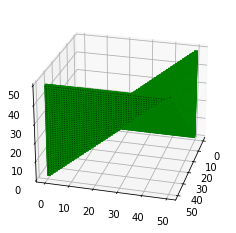

In [6]:
import matplotlib.pyplot as plt
import numpy as np

resolution=50
dims = 3
x1_ind, x2_ind, x3_ind = np.indices([resolution for i in range(dims)])

x1_ind = np.ravel(x1_ind)
x2_ind = np.ravel(x2_ind)
x3_ind = np.ravel(x3_ind)

truth_array = np.zeros(len(x1_ind))

res_vals = np.linspace(0,1, resolution, endpoint=True)

cube_lin = ((res_vals[x1_ind] > res_vals[x3_ind]) & (res_vals[x2_ind] < res_vals[x3_ind])) | ((res_vals[x1_ind] < res_vals[x3_ind]) & (res_vals[x2_ind] > res_vals[x3_ind]))

cube =  cube_lin.reshape(resolution, resolution, resolution)

colors = np.empty(cube.shape, dtype=object)
colors[cube] = 'green'

ax = plt.figure().add_subplot(projection='3d')
ax.voxels(cube, facecolors=colors, edgecolor='green')

ax.view_init(25, 15)

plt.draw()
plt.show()